In [ ]:
import os  # For accessing environment variables and system functions
import json  # For handling JSON data
import getpass  # For securely getting user input for passwords
import operator  # For performing arithmetic operations

from langgraph.graph import END  # For defining the end of a graph workflow
from langchain_groq import ChatGroq  # For interacting with the ChatGroq model
from langchain.schema import Document  # For defining document schema
from langgraph.graph import StateGraph  # For creating and managing state graphs
from langchain_nomic.embeddings import NomicEmbeddings  # For generating document embeddings
from langchain_community.document_loaders import WebBaseLoader  # For loading documents from the web
from langchain_core.messages import HumanMessage, SystemMessage  # For defining message types
from langchain_community.vectorstores import SKLearnVectorStore  # For storing and retrieving document embeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter  # For splitting text into chunks
from langchain_community.tools.tavily_search import TavilySearchResults  # For performing web searches

from typing import List, Annotated  # For type annotations
from typing_extensions import TypedDict  # For defining typed dictionaries

from IPython.display import display, Markdown, clear_output, Image  # For displaying content in Jupyter notebooks

In [25]:
# This function clears the current output and displays the given text as Markdown
def display_md(text):
    clear_output()  # Clear the current output in the notebook
    display(Markdown(text))  # Display the given text as Markdown

# This function formats the given JSON data as a pretty-printed JSON string and displays it as Markdown
def display_json(json_data):
    display(Markdown(f"```json\n{json.dumps(json_data, indent=2)}\n```"))

In [ ]:
# Set environment variable if not already set
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}")

In [ ]:
# Set GROQ_API_KEY if not already set
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

In [44]:
# Initialize ChatGroq with specified model and parameters
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [45]:
# Initialize ChatGroq with JSON response format
llm_json_mode = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    response_format={"type": "json_object"},
)

c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\langchain_groq\chat_models.py:362: UserWarning: WARNING! response_format is not default parameter.
                    response_format was transferred to model_kwargs.
                    Please confirm that response_format is what you intended.
  warnings.warn(


In [46]:
# Define messages for the ChatGroq model
messages = [
    (
        "system",
        "You are a special kind of agent that when I give you a question, you will get the answer for that question by solving it step-by-step.",
    ),
    ("human", "How many `r` letters in the word `strawberry`"),
]

# Invoke the ChatGroq model with the defined messages
ai_msg = llm.invoke(messages)

In [47]:
# Display the response from the ChatGroq model
ai_msg

AIMessage(content="To find the number of `r` letters in the word `strawberry`, let's break it down step by step:\n\n1. **Write down the word**: The word is `strawberry`.\n2. **Separate the letters**: Separate each letter in the word to count them individually: `s-t-r-a-w-b-e-r-r-y`.\n3. **Count the `r` letters**: Now, count how many times the letter `r` appears in the separated letters:\n   - The first `r` is after `t`.\n   - The second `r` is after `e`.\n   - There is another `r` right after the second `r`.\n4. **Conclusion**: There are **3** `r` letters in the word `strawberry`.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 162, 'prompt_tokens': 79, 'total_tokens': 241, 'completion_time': 0.827973507, 'prompt_time': 0.018752949, 'queue_time': 0.806259212, 'total_time': 0.846726456}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'stop', 'logprobs': None}, id='run-ca912c48-a142-4367-a74c-4efb2ee45296-0

In [48]:
# Display the response
display(Markdown(ai_msg.content))

To find the number of `r` letters in the word `strawberry`, let's break it down step by step:

1. **Write down the word**: The word is `strawberry`.
2. **Separate the letters**: Separate each letter in the word to count them individually: `s-t-r-a-w-b-e-r-r-y`.
3. **Count the `r` letters**: Now, count how many times the letter `r` appears in the separated letters:
   - The first `r` is after `t`.
   - The second `r` is after `e`.
   - There is another `r` right after the second `r`.
4. **Conclusion**: There are **3** `r` letters in the word `strawberry`.

### Search


In [93]:
# Set TAVILY_API_KEY environment variable
_set_env("TAVILY_API_KEY")

# Enable parallelism for tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "true"

### Tracing


In [72]:
# Set LANGSMITH_API_KEY environment variable
_set_env("LANGSMITH_API_KEY")

# Enable LangChain tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"

# Set LangChain project name
os.environ["LANGCHAIN_PROJECT"] = "self-correcting-rag-system"

### Vectorestore


In [3]:
# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [4]:
# Load documents from URLs
docs = [WebBaseLoader(url).load() for url in urls]

# Flatten the list of documents
doc_list = [item for sublist in docs for item in sublist]

In [5]:
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200
)
doc_splits = text_splitter.split_documents(doc_list)

In [9]:
# Add document chunks to vector database
# Note: SKLearnVectorStore is used to store and retrieve document embeddings for similarity search
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(
        model="nomic-embed-text-v1",
        inference_mode="local"
    )
)

c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  warnings.warn(
c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
# Create a retriever to fetch top 3 similar documents
retriever = vectorstore.as_retriever(k=3)

### Components


#### Router


In [118]:
# Prompt instructions for routing user questions
router_instructions = """
    You are an expert at routing a user question to a vectorstore or web search.
    
    The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
    
    Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.
    
    Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question.
"""

In [18]:
# Test router with different types of questions

# Test with a question likely to require web search
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [
        HumanMessage(
            content="Who is favored to win the NFC Championship game in the 2024 season?"
        )
    ]
)

# Test with another question likely to require web search
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the models released today for llama 3.2?")]
)

# Test with a question likely to be answered by the vectorstore
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the types of agent memory?")]
)

In [ ]:
# Print the results of the test router invocations
print(json.loads(test_web_search.content))
print(json.loads(test_web_search_2.content))
print(json.loads(test_vector_store.content))

#### Retrieval Grader


In [38]:
# Instructions for the document grader
doc_grader_instructions = """
    You are a grader assessing relevence of a retrieved document to a user question.
    If the document contains keyword(s) or sementic meaning related to the question, grade it as relevant.
"""

# Grader prompt
doc_grader_prompt = """**Here is the retrieved document:** \n\n {document} \n\n **Here is the user question:** \n\n {question}.\n\n
This carefully and objectively assess the document contains at least some information that is relevant to the question.
Return JSON with single key, `binary_score`, that is 'yes' or 'no' score to indicate whether the document is contains at least some information that is relevant to the question."""

In [39]:
# Test the document grader
question = "What is Chain of thought prompting?"
docs = retriever.invoke(question)
doc_text = docs[1].page_content

# Format the grader prompt with the retrieved document and the question
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_text, question=question
)

c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [40]:
# Display the formatted grader prompt as Markdown
display_md(doc_grader_prompt_formatted)

**Here is the retrieved document:** 

 Use an iterative Monte Carlo search method to improve the best candidates by proposing semantically similar variants via prompts like Generate a variation of the following instruction while keeping the semantic meaning.\n\nInput: ...\n\nOutput:...


To construct chain-of-thought prompts automatically, Shum et al. (2023) suggested augment-prune-select, a three-step process:

Augment: Generate multiple pseudo-chains of thought given question using few-shot or zero-shot CoT prompts;
Prune: Prune pseudo chains based on whether generated answers match ground truths.
Select: Apply a variance-reduced policy gradient strategy to learn the probability distribution over selected examples, while considering the probability distribution over examples as policy and the validation set accuracy as reward.

Zhang et al. (2023) instead adopted clustering techniques to sample questions and then generates chains. They observed that LLMs tend to make certain types of mistakes. One type of errors can be similar in the emebedding space and thus get grouped together. By only sampling one or a few from frequent-error clusters, we can prevent too many wrong demonstrations of one error type and collect a diverse set of examples.

Question clustering: Embed questions and run $k$-means for clustering.
Demonstration selection: Select a set of representative questions from each cluster; i.e. one demonstration from one cluster. Samples in each cluster are sorted by distance to the cluster centroid and those closer to the centroid are selected first.
Rationale generation: Use zero-shot CoT to generate reasoning chains for selected questions and construct few-shot prompt to run inference.

Augmented Language Models#
A survey on augmented language models by Mialon et al. (2023) has great coverage over multiple categories of language models augmented with reasoning skills and the ability of using external tools. Recommend it.
Retrieval#
Often we need to complete tasks that require latest knowledge after the model pretraining time cutoff or internal/private knowledge base. In that case, the model would not know the context if we don’t explicitly provide it in the prompt. Many methods for Open Domain Question Answering depend on first doing retrieval over a knowledge base and then incorporating the retrieved content as part of the prompt. The accuracy of such a process depends on the quality of both retrieval and generation steps.
Lazaridou et al. (2022) studied how to use Google Search for document retrieval to augment LLMs. Given a question $q$, clean text is extracted out of 20 URLs returned by Google, resulting in a set of documents. Because these documents are long, each document is split into paragraphs of 6 sentences, $\{p\}$. Paragraphs are ranked by TF-IDF based cosine similarity between evidence paragraphs and the query. Only the most relevant paragraph is used in the prompt to produce an answer $a$.
For closed-book QA, each demonstration is formatted as follows to construct few-shot prompts. Swapping the question with the evidence (longer distance between questions and answers) is found to consistently yield lower results across all datasets.
Evidence: ...
Question: ...
Answer: ...
The answer probability is computed in three ways:

RAG style, $p(a_i \mid q) = \sum_{i=1}^n p_\text{tf-idf} (p_i \mid q) \cdot p_\text{LM}(a_i \mid q, p_i)$, where $p_\text{tf-idf} (p_i \mid q)$ is the normalized cosine similarities between the TF-IDF passage and question representations.
Noisy channel inference, $p(a_i\mid q) = \frac{p_\text{LM}(q \mid a_i, p_i) \cdot p_\text{LM}(a_i \mid p_i)}{p_\text{LM}(q \mid p_i)}$
Product-of-Experts (PoE), combines all probabilities used above in addition to $p_\text{LM}(p_i \mid q)$. 

 **Here is the user question:** 

 What is Chain of thought prompting?.


This carefully and objectively assess the document contains at least some information that is relevant to the question.
Return JSON with single key, `binary_score`, that is 'yes' or 'no' score to indicate whether the document is contains at least some information that is relevant to the question.

In [51]:
# Get the grading result
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)

# Parse and display the result
json.loads(result.content)

{'binary_score': 'yes'}

#### Generate


In [53]:
# Prompt for the retrieval-augmented generation (RAG) model
rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:
{context}
Think carefully about the context.

Now, review the user question:
{question}

Provide an answer to this question using only the above context.
Use three sentences maximum and keep the answer concise.

Answer:"""


In [54]:
# Post-processing function to format documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [57]:
# Test the RAG model with a question
docs = retriever.invoke(question)
docs_txt = format_docs(docs)

# Format the RAG prompt with the retrieved documents and the question
rag_prompt_formatted = rag_prompt.format(
    context=docs_txt,
    question=question
)

# Generate the answer using the RAG model
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [58]:
# Display the generated answer as Markdown
display_md(generation.content)

Chain of thought prompting is a technique that elicits reasoning in large language models by generating multiple pseudo-chains of thought given a question. This process involves augmenting, pruning, and selecting examples to learn the probability distribution over selected examples, as suggested by Shum et al. (2023). The goal of chain of thought prompting is to improve the accuracy of complex questions by providing a step-by-step thought process, as seen in methods like Tree of Thoughts and Self-Ask.

#### Hallucination Grader


In [62]:
# Hallucination grader instructions
hallucination_grader_instructions = """You are a teacher grading a quiz.
You will be given `FACTS` and `STUDENT ANSWER`.\n\n

Here is the grade criteria:\n
1. Ensure the `STUDENT ANSWER` is grounded in the `FACTS`
2. Ensure the `STUDENT ANSWER` does not contain "hallucinated" information outside the scope of the `FACTS`.\n\n

Score:
"""

# Display the hallucination grader instructions as Markdown
display_md(hallucination_grader_instructions)

You are a teacher grading a quiz.
You will be given `FACTS` and `STUDENT ANSWER`.



Here is the grade criteria:

1. Ensure the `STUDENT ANSWER` is grounded in the `FACTS`
2. Ensure the `STUDENT ANSWER` does not contain "hallucinated" information outside the scope of the `FACTS`.



Score:


In [63]:
# Grader prompt for hallucination detection
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: \n\n {generation}. \n\n
Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` is grounded in the `FACTS`, and `explanation` which contains an explanation of the score."""

# Display the hallucination grader prompt as Markdown
display_md(hallucination_grader_prompt)

FACTS: 

 {documents} 

 STUDENT ANSWER: 

 {generation}. 


Return JSON with two two keys, `binary_score` is 'yes' or 'no' score to indicate whether the `STUDENT ANSWER` is grounded in the `FACTS`. And a key, explanation, that contains a explanation of the score.

In [79]:
# Test the hallucination grader using the documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt,
    generation=generation.content
)

result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)

# Display the result as JSON
display_json(json.loads(result.content))

```json
{
  "binary_score": "yes",
  "explanation": "The student answer is grounded in the facts as it accurately describes chain of thought prompting and its goal, referencing relevant research by Shum et al. (2023) and mentioning specific methods like Tree of Thoughts and Self-Ask. The answer does not contain hallucinated information outside the scope of the provided facts."
}
```

#### Answer Grader


In [86]:
# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz.
You will be given `QUESTION` and a `STUDENT ANSWER`.\n\n

Here is the grade criteria to follow:
1. The `STUDENT ANSWER` helps to answer the `QUESTION`

Score:\n
A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score.
The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.
A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
Explain your reasoning in a step by step manner to ensure your reasoning and conclusion are correct.
Avoid simply stating the correct answer at the outset."""

# Grader prompt for answer grading
answer_grader_prompt = """QUESTION: \n\n {question} \n\nSTUDENT ANSWER:\n\n{generation} \n\n
Return JSON with two keys: `binary_score` which is 'yes' or 'no' to indicate whether the `STUDENT ANSWER` meets the criteria, and `explanation` which contains an explanation of the score."""

# Display the answer grader prompt as Markdown
display_md(answer_grader_prompt)

QUESTION: 

 {question} 

STUDENT ANSWER:

{generation} 


Return JSON with two keys, `binary_score` is 'yes' or 'no' score to indicate whether the `STUDENT ANSWER` meets the criteria. And a key, explanation, that contains a explanation of the score.

In [87]:
# Test the answer grader with a question and an answer
question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and LLama 3.2 90B Vision Instruct, which are available on Azure AI Model CAtalog via managed compute. These models are part of Meta's first foray into multimodel AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the order text-only Llama 3.1 models."

In [89]:
# Test using the question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question,
    generation=answer
)

result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)

# Display the result as JSON
display_json(json.loads(result.content))

```json
{
  "binary_score": "yes",
  "explanation": "The student's answer meets the criteria because it directly addresses the question by listing the vision models released as part of Llama 3.2, specifically mentioning Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct. The answer also provides additional context about the models' availability and their significance in relation to other models and technologies, which is acceptable according to the grading criteria."
}
```

### Web Search Tool


#### Search


In [94]:
# Initialize the web search tool with top 3 search results
web_search_tool = TavilySearchResults(k=3)

## Graph


In [95]:
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in,
    each node
    """
    
    question: str # user question
    generation: str # llm generation
    web_search: str # binary decision to run web search
    max_retries: int # max number of retries for answer generation
    answers: int # number of answers generated
    loop_step: Annotated[int, operator.add] # current loop step
    documents: List[str] # list of retrieved documents

### Nodes

#### retrieve()


In [97]:
def retrieve(state):
    """
    Retrieve documents from vectorstore
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    
    print("---RETRIEVE---")
    question = state["question"]
    
    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    
    return {"documents": documents}

generate()


In [98]:
def generate(state):
    """
    Generate answer using RAG on retrieved documents
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(
        context=docs_txt,
        question=question
    )
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    
    return {
        "generation": generation,
        loop_step: loop_step + 1
    }

grade_documents()


In [99]:
def grade_documents(state):
    """
    Determine whether the retrieved documents are relevant to the question
    If any document is not relevent, we will set a flag to run web search
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Filtered out irrelevant documents and updated web_serarch state
    """
    
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # score each doc
    filtered_docs = []
    
    web_search = "No"
    
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document = d.page_content,
            question=question
        )
        
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        
        grade = json.loads(result.content)["binary_score"]
        
        # document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # we do not include the document in filtered_docs
            # we set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    
    return {
        "documents": filtered_docs,
        "web_search": web_search
    }

web_search()


In [100]:
def web_search(state):
    """
    Web search based on the question
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Appended web results to documents
    """
    
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])
    
    # web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents}

### Edges


route_question()


In [101]:
def route_question(state):
    """
    Route question to web search or RAG
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Next node to call
    """
    
    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        return "web_search"
    else:
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [103]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]
    
    if web_search == "Yes":
        # all documents have been filtered check_relevance
        # we will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        
        return "web_search"
    else:
        # we have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

decide_to_generate()


In [104]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Binary decision for next node to call
    """
    
    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]
    
    if web_search == "Yes":
        # all documents have been filtered check_relevance
        # we will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        
        return "websearch"
    else:
        # we have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

grade_generation_v_documents_and_question()


In [105]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Decision for next node to call
    """
    
    print("---CHECK HALUCINATIONS")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # default to 3 if not provided
    
    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents = format_docs(documents),
        generation = generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]
    
    # check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        
        # test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question,
            generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        
        grade = json.loads(result.content)["binary_score"]
        
        if grade == "yes":
            print("---DECISION: GENERATION ANSWERS QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

### Control Flow


In [113]:
# Initialize the workflow with the GraphState
workflow = StateGraph(GraphState)

In [114]:
# define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate

In [115]:
# build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

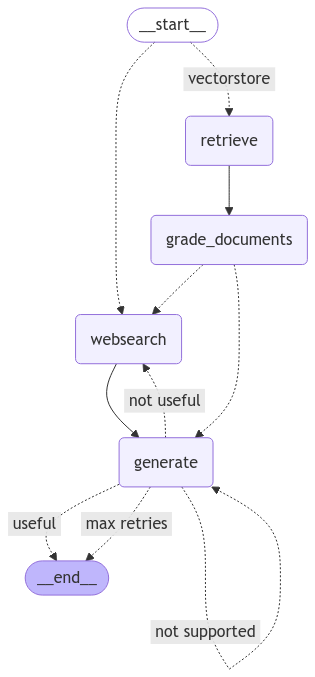

In [116]:
# Compile the workflow graph
graph = workflow.compile()

# Display the compiled graph as an image
display(Image(graph.get_graph().draw_mermaid_png()))

In [119]:
# Define inputs for the workflow
inputs = {"question": "What are the types of agent memory?", "max_retries": 3}

# Stream events from the compiled graph
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '58ef9b80-7625-463d-aa5b-1ea9009017f4', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks

c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\Makara\.conda\envs\ai-agents-env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
{'question': 'What are the types of agent memory?', 'web_search': 'No', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '58ef9b80-7625-463d-aa5b-1ea9009017f4', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanni

In [120]:
# Test the workflow on a current events question
inputs = {
    "question": "What are the models released today for llama3.2?",
    "max_retries": 3,
}

# Stream events from the compiled graph
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---


KeyError: 'web_search'